# Predictions for 2025

In this notebook we'll gather all the predictions made for all the covariates in the notebooks inside the `covariates` folder. 

We'll take all the predictions for 2025 saved in the `predictions` folder, merge them all and them finally build our ML model - like it was done in the `03-ML.ipynb` notebook - but this time to make the inference

## Building the Future DataFrame

Once we have all the future values for all covariates we can build our Future DataFrame that'll be the input for our model.

In [38]:
import pandas as pd 
import glob  
from mlforecast import MLForecast
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from covariates.utils import get_filtered_data

In [3]:
#Reading the data
df = get_filtered_data("../data/tidy_data.csv")

### Reading all the predictions done for the covariates

In [5]:
future_df_paths = glob.glob("../predictions/*.csv")

# List with all future dataframes
dfs = [pd.read_csv(df_path) for df_path in future_df_paths]

In [6]:
#Merging all DataFrames 

def merge_df(df_left, df_right):
    return df_left.merge(df_right, on=["date"], how="inner") 

for i in range(len(dfs) - 1):
    new_df = merge_df(dfs[0], dfs[1])
    dfs[0] = new_df #assign the merged df to the first position
    dfs.pop(1) #remove item from position 1

In [7]:
new_df

,date,exports,imports,milk_production,population,total_supply,uht_milk_industry,uht_milk_market,unemployment,wage_mass
0,2025-01-01,5.167732,62.840082,2237.481631,212.941754,2387.206559,4.178417,4.799913,0.058776,357190.526406
1,2025-02-01,35.505059,76.249004,1988.317831,213.013372,2123.205264,4.258746,4.835795,0.059608,359698.601339
2,2025-03-01,15.319815,156.256014,2072.715431,213.084990,2218.443702,4.499035,4.920325,0.060318,355609.176271
3,2025-04-01,10.151093,48.015291,1936.065331,213.156609,2072.777520,4.613395,5.088675,0.058138,340650.451204
4,2025-05-01,5.701574,97.500741,1953.020831,213.228227,2104.765002,4.726701,5.199232,0.055990,341965.726136
5,2025-06-01,5.537547,80.418765,1954.374131,213.299845,2106.704717,4.982266,5.400052,0.053923,343917.155247
6,2025-07-01,7.723967,107.969371,2095.977631,213.371463,2255.897259,4.984853,5.602651,0.052773,346175.084357
7,2025-08-01,12.848379,115.930238,2156.845331,213.436788,2321.478936,4.741268,5.595997,0.051316,349731.913468
8,2025-09-01,11.342814,103.699925,2131.977131,213.506527,2302.152076,4.568759,5.440146,0.049965,352497.742578
9,2025-10-01,5.349793,205.592904,2213.269131,213.576266,2390.067730,4.400620,5.293622,0.048353,354953.371689


There's one covariate left which is `per_capita_supply` but that is simple the `total_supply` / `population` 

In [8]:
new_df['per_capita_supply'] = new_df['total_supply'] / new_df['population']

## Converting DataFrame to Nixtla API format

In [9]:
class Preprocess:

    def __init__(self, df: pd.DataFrame, date_col:str, target_col:str):
        self.df = df  
        self._raw = self.df.copy() 
        self.date_col = date_col 
        self.target_col = target_col 

    def __rename_columns(self):
        df_preprocessed = self.df.rename(columns={self.date_col: 'ds', self.target_col: 'y'}) 
        return df_preprocessed 

    def _create_id(self): 
        self.df.insert(0, 'unique_id', 0)

    def drop_nulls(self):
        self.df.dropna(axis=0, inplace=True) 
    
    def _preprocess(self):        
        self._create_id()
        self.drop_nulls()
        df_preprocessed = self.__rename_columns() 
        return df_preprocessed

In [10]:
engine = Preprocess(new_df, date_col='date', target_col='farmgate_milk_price') 
new_df = engine._preprocess() 

In [12]:
new_df.head()

,unique_id,ds,exports,imports,milk_production,population,total_supply,uht_milk_industry,uht_milk_market,unemployment,wage_mass,per_capita_supply
0,0,2025-01-01,5.167732,62.840082,2237.481631,212.941754,2387.206559,4.178417,4.799913,0.058776,357190.526406,11.210608
1,0,2025-02-01,35.505059,76.249004,1988.317831,213.013372,2123.205264,4.258746,4.835795,0.059608,359698.601339,9.967474
2,0,2025-03-01,15.319815,156.256014,2072.715431,213.084990,2218.443702,4.499035,4.920325,0.060318,355609.176271,10.411074
3,0,2025-04-01,10.151093,48.015291,1936.065331,213.156609,2072.777520,4.613395,5.088675,0.058138,340650.451204,9.724200
4,0,2025-05-01,5.701574,97.500741,1953.020831,213.228227,2104.765002,4.726701,5.199232,0.055990,341965.726136,9.870949


## Fitting the ML Model

This time, we can fit our model on the entire training data, starting at 2015. 

We'll load the model we saved at the `models` folder. That model can be seen at the notebook `03-ML.ipynb`, where we have got a good model using a Bayesian Ridge on all covariates.

In [26]:
forecast_model = MLForecast.load("../models") 

In [27]:
y_preds = forecast_model.predict(12, X_df=new_df)

In [28]:
#Select the Bayesian Ridge Predictions
preds = y_preds['BayesianRidge']

In [34]:
new_df['farmgate_milk_price'] = preds.values 
new_df['ds'] = pd.to_datetime(new_df['ds'])

In [35]:
new_df

,unique_id,ds,exports,imports,milk_production,population,total_supply,uht_milk_industry,uht_milk_market,unemployment,wage_mass,per_capita_supply,farmgate_milk_price
0,0,2025-01-01,5.167732,62.840082,2237.481631,212.941754,2387.206559,4.178417,4.799913,0.058776,357190.526406,11.210608,2.524503
1,0,2025-02-01,35.505059,76.249004,1988.317831,213.013372,2123.205264,4.258746,4.835795,0.059608,359698.601339,9.967474,2.588176
2,0,2025-03-01,15.319815,156.256014,2072.715431,213.084990,2218.443702,4.499035,4.920325,0.060318,355609.176271,10.411074,2.660943
3,0,2025-04-01,10.151093,48.015291,1936.065331,213.156609,2072.777520,4.613395,5.088675,0.058138,340650.451204,9.724200,2.764106
4,0,2025-05-01,5.701574,97.500741,1953.020831,213.228227,2104.765002,4.726701,5.199232,0.055990,341965.726136,9.870949,2.813236
5,0,2025-06-01,5.537547,80.418765,1954.374131,213.299845,2106.704717,4.982266,5.400052,0.053923,343917.155247,9.876729,2.938800
6,0,2025-07-01,7.723967,107.969371,2095.977631,213.371463,2255.897259,4.984853,5.602651,0.052773,346175.084357,10.572629,3.003393
7,0,2025-08-01,12.848379,115.930238,2156.845331,213.436788,2321.478936,4.741268,5.595997,0.051316,349731.913468,10.876658,2.941915
8,0,2025-09-01,11.342814,103.699925,2131.977131,213.506527,2302.152076,4.568759,5.440146,0.049965,352497.742578,10.782584,2.846426
9,0,2025-10-01,5.349793,205.592904,2213.269131,213.576266,2390.067730,4.400620,5.293622,0.048353,354953.371689,11.190699,2.753319


## Visualizing the Predictions on Test Data

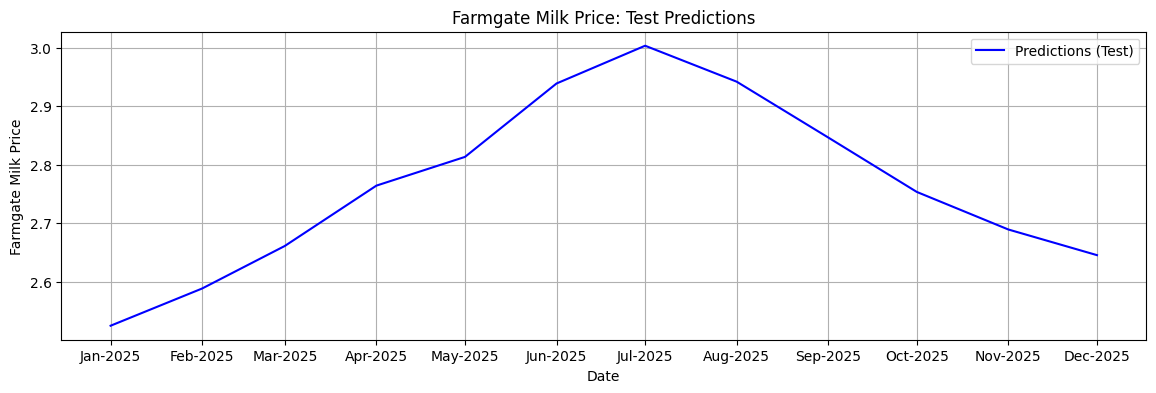

In [39]:
# Plot
plt.figure(figsize=(14, 4))

# Fitted (test only)
plt.plot(new_df["ds"], new_df["farmgate_milk_price"],
         label="Predictions (Test)", color="blue") 

plt.title("Farmgate Milk Price: Test Predictions")
plt.xlabel("Date") 
plt.xticks()
plt.ylabel("Farmgate Milk Price")

# Force monthly ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))

plt.legend()
plt.grid()
plt.show()

## Visualizing the Predictions on the Historical Data

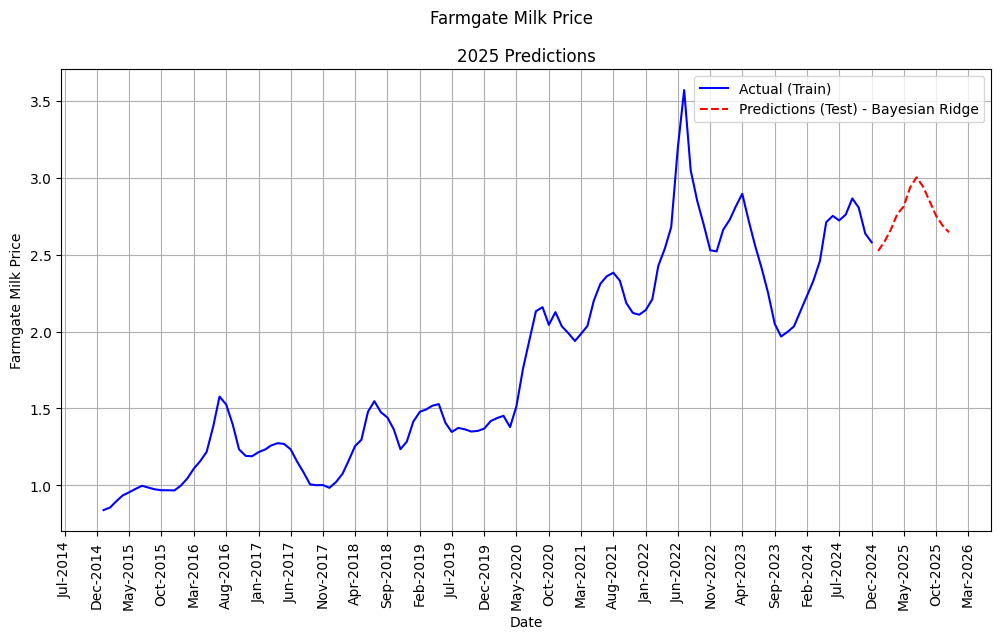

In [47]:
# Plot
plt.figure(figsize=(12, 6))

# Actual (train only)
plt.plot(df["date"], df["farmgate_milk_price"],
         label="Actual (Train)", color="blue") 

# Predictions (test only)
plt.plot(new_df["ds"], new_df["farmgate_milk_price"],
         label="Predictions (Test) - Bayesian Ridge", color="red", linestyle="--")

plt.title("2025 Predictions") 
plt.suptitle("Farmgate Milk Price")
plt.xlabel("Date")
plt.ylabel("Farmgate Milk Price")

# Force monthly ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))

# Rotate for readability
plt.xticks(rotation=90)

plt.legend() 
plt.grid()
plt.show()

## Saving the 2025 Predictions


In [52]:
final_df = new_df.drop(columns=['unique_id']) 
final_df.rename(columns={'ds':'date'}) 

final_df.to_csv("../predictions/0 - 2025_predictions.csv", index=False)